# Knowledge Discovery & Data Analytics 2 Final Project
### 🇯🇲 JAM Dolla Identifier 💵 💶 💷
***Done by:*** *Denecian Dennis, Elombe Calvert, Simon Lee, Clifton Lee, Win Phyo.*

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os

import cv2
import imghdr

import matplotlib.pyplot as plt

#### We begin by checking our dataset for correct filetypes or usable images. The function below will detect any incompatible images, and delete them from the dataset.

In [2]:
def check_images(s_dir, ext_list):
    """
    
    """
    bad_images = []
    bad_ext = []
    s_list = os.listdir(s_dir)
    for klass in s_list:
        klass_path = os.path.join (s_dir, klass)
        print ('Processing class directory ', klass)
        if os.path.isdir(klass_path):
            file_list = os.listdir(klass_path)
            for f in file_list:               
                f_path = os.path.join (klass_path,f)
                tip = imghdr.what(f_path)
                if ext_list.count(tip) == 0:
                  bad_images.append(f_path)
                if os.path.isfile(f_path):
                    try:
                        img = cv2.imread(f_path)
                        shape = img.shape
                    except:
                        print('file ', f_path, ' is not a valid image file')
                        bad_images.append(f_path)
                        os.remove(f_path)
                else:
                    print('*** fatal error, you a sub directory ', f, ' in class directory ', klass)
        else:
            print ('*** WARNING*** you have files in ', s_dir, ' it should only contain sub directories')
    return bad_images, bad_ext

source_dir = r'/Users/simonlee/Desktop/KDDA2/Final_Project/JMD-DataSet'

# List of acceptable extensions
good_exts = ['jpg', 'png', 'jpeg', 'gif', 'bmp' ] 
bad_file_list, bad_ext_list=check_images(source_dir, good_exts)

if len(bad_file_list) !=0:
    print('Please see improper image files listed below.')
    for i in range (len(bad_file_list)):
        print (bad_file_list[i])
else:
    print('No improper image files were found!')

Processing class directory  .DS_Store
*** WARNING*** you have files in  /Users/simonlee/Desktop/KDDA2/Final_Project/JMD-DataSet  it should only contain sub directories
Processing class directory  500
file  /Users/simonlee/Desktop/KDDA2/Final_Project/JMD-DataSet/500/.DS_Store  is not a valid image file
Processing class directory  1000
file  /Users/simonlee/Desktop/KDDA2/Final_Project/JMD-DataSet/1000/.DS_Store  is not a valid image file
Please see improper image files listed below.
/Users/simonlee/Desktop/KDDA2/Final_Project/JMD-DataSet/500/.DS_Store
/Users/simonlee/Desktop/KDDA2/Final_Project/JMD-DataSet/500/.DS_Store
/Users/simonlee/Desktop/KDDA2/Final_Project/JMD-DataSet/1000/.DS_Store
/Users/simonlee/Desktop/KDDA2/Final_Project/JMD-DataSet/1000/.DS_Store


#### Split the data into training and validation sets

In [3]:
image_size = (150, 150)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/Users/simonlee/Desktop/KDDA2/Final_Project/JMD-DataSet",
    validation_split = 0.25,
    subset = "training",
    seed = 14,
    image_size = image_size,
    batch_size = batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/Users/simonlee/Desktop/KDDA2/Final_Project/JMD-DataSet",
    validation_split = 0.25,
    subset = "validation",
    seed = 14,
    image_size = image_size,
    batch_size = batch_size,
)

Found 543 files belonging to 2 classes.
Using 408 files for training.
Found 543 files belonging to 2 classes.
Using 135 files for validation.


#### Let's take a quick look at our data

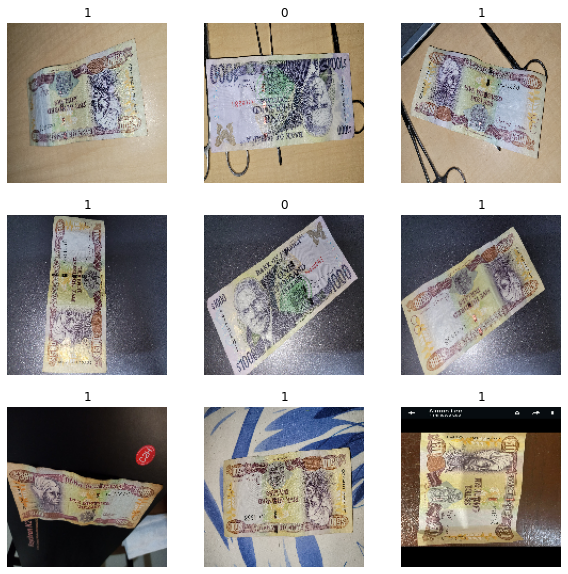

In [4]:
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

#### We'll use data augmentation to artificially increase the size of our dataset by training the model on copies of each image with slight alterations.

In [5]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

#### Let's take a look at how the augmented data looks

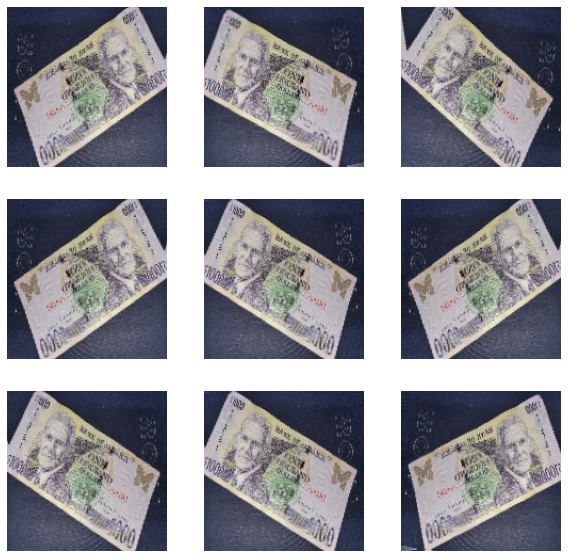

In [6]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

#### We'll configure the dataset for performance

In [7]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

#### Now we're finally ready to build our model

In [8]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
#keras.utils.plot_model(model, show_shapes=True)


#### Now we'll train the model

In [9]:
epochs = 15

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer = keras.optimizers.Adam(1e-3),
    loss = "binary_crossentropy",
    metrics = ["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

model.save('dollar-model', save_format='h5')

Epoch 1/15
13/13 [==============================] - ETA: 0s - loss: 0.6117 - accuracy: 0.6740

/Users/simonlee/opt/anaconda3/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


13/13 [==============================] - 64s 4s/step - loss: 0.6117 - accuracy: 0.6740 - val_loss: 0.6932 - val_accuracy: 0.4963
Epoch 2/15
13/13 [==============================] - 60s 3s/step - loss: 0.3943 - accuracy: 0.8358 - val_loss: 0.6931 - val_accuracy: 0.4963
Epoch 3/15
13/13 [==============================] - 61s 4s/step - loss: 0.2331 - accuracy: 0.9118 - val_loss: 0.6932 - val_accuracy: 0.5037
Epoch 4/15
13/13 [==============================] - 63s 4s/step - loss: 0.2013 - accuracy: 0.9167 - val_loss: 0.6929 - val_accuracy: 0.4889
Epoch 5/15
13/13 [==============================] - 60s 3s/step - loss: 0.1371 - accuracy: 0.9608 - val_loss: 0.6935 - val_accuracy: 0.5037
Epoch 6/15
13/13 [==============================] - 59s 3s/step - loss: 0.1216 - accuracy: 0.9412 - val_loss: 0.6983 - val_accuracy: 0.5037
Epoch 7/15
13/13 [==============================] - 60s 4s/step - loss: 0.1537 - accuracy: 0.9363 - val_loss: 0.6973 - val_accuracy: 0.5037
Epoch 8/15
13/13 [=============

In [10]:
img = keras.preprocessing.image.load_img(
    "/Users/simonlee/Desktop/KDDA2/Final_Project/JMD-DataSet/500/29.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent 1000 and %.2f percent 500."
    % (100 * (1 - score), 100 * score)
)

This image is 14.79 percent 1000 and 85.21 percent 500.
